## Notebook Purpose
This notebook is used to compute and plot bin-wise debris-cover and ice cliff statistics (Section 6.5, Figure 7, and Table 4).  

#### Last updated: September 5, 2023

## TODO:
- Update imports when new library has been built up with all updates
-Generalise path to data products during revisions, after the data distribution plan is finalized


In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt
from imview import pltlib
import pandas as pd
from pygeotools.lib import warplib,geolib,iolib,malib,filtlib,timelib
import os,sys,glob,shutil
from debris_cover_smb import glac_dyn, constants, geospatial

In [3]:
%matplotlib inline

In [13]:
def melt_summary_function(melt_df):
    
    mask = melt_df['med_bg_dhdt'] >= 0
    enhancement_factor = melt_df['med_hotspot_dhdt']/melt_df['med_bg_dhdt']
    ice_enhancement_factor = (melt_df['med_hotspot_dhdt'])/(melt_df['med_bg_dhdt']/melt_df['med_deb_melt_enhancement'])
    melt_debris_total = ((melt_df['med_bg_dhdt'] * melt_df['area_bg']) + (melt_df['med_hotspot_dhdt'] * melt_df['area_hotspot']))/(melt_df['area_bg'] + melt_df['area_hotspot'])
    #melt_by_icecliff = melt_debris_total-melt_df['med_bg_dhdt']
    #melt_contribution = melt_by_icecliff/(melt_debris_total)
    melt_contribution2 = (melt_df['med_hotspot_dhdt']*melt_df['area_hotspot'])/((melt_df['med_hotspot_dhdt']*melt_df['area_hotspot'])+(melt_df['med_bg_dhdt']*melt_df['area_bg']))
    melt_contribution2_lower = ((melt_df['med_hotspot_dhdt']-melt_df['smb_error_med'])*melt_df['area_hotspot'])/(
                                ((melt_df['med_hotspot_dhdt']-melt_df['smb_error_med'])*melt_df['area_hotspot']) + 
                                ((melt_df['med_bg_dhdt']-melt_df['smb_error_med'])*melt_df['area_bg']))
    #melt_contribution2_lower_clip = np.clip(melt_contribution2_lower*100,a_min=0,a_max=100)
    #mask_bg = (melt_df['med_bg_dhdt']+melt_df['divQ2_mean_stddev'])>=0
    #melt_contribution2_lower[mask_bg] = melt_contribution2[mask_bg]
    
    melt_contribution2_upper = ((melt_df['med_hotspot_dhdt']+melt_df['smb_error_med'])*melt_df['area_hotspot'])/(
                                ((melt_df['med_hotspot_dhdt']+melt_df['smb_error_med'])*melt_df['area_hotspot']) + 
                                ((melt_df['med_bg_dhdt']+melt_df['smb_error_med'])*melt_df['area_bg']))
    mask_bg = (melt_df['med_bg_dhdt']+melt_df['smb_error_med'])>=0
    melt_contribution2_upper[mask_bg] = melt_contribution2[mask_bg]
    
    #melt_contribution2_upper_clip = np.clip(melt_contribution2_upper*100,0,100)
    
    ice_cliff_area = ((melt_df.area_hotspot)/(melt_df.area_bg+melt_df.area_hotspot))*100
    # create mask to restrict analysis to bins where debris is also melting
    #melt_contribution[mask] = np.nan
    enhancement_factor[mask] = np.nan
    ice_enhancement_factor[mask] = np.nan
    melt_contribution2[mask] = np.nan
    melt_contribution2_lower[mask] = np.nan
    melt_contribution2_upper[mask] = np.nan
    
    #ice_cliff_area[mask] = np.nan
    melt_df['melt_debris_total'] = melt_debris_total
    melt_df['ice_cliff_area_perc'] = ice_cliff_area
    #melt_df['ice_cliff_melt_contribution'] = melt_contribution * 100
    melt_df['ice_cliff_melt_contribution2'] = melt_contribution2 * 100
    #melt_df['ice_cliff_melt_contribution2_lower'] = melt_contribution2_lower * 100
    #melt_df['ice_cliff_melt_contribution2_upper'] = melt_contribution2_upper * 100
    melt_df['ice_cliff_melt_contribution2_lower'] = melt_contribution2_lower * 100
    melt_df['ice_cliff_melt_contribution2_upper'] = melt_contribution2_upper * 100
    melt_df['ice_cliff_enhancement_factor'] = enhancement_factor 
    melt_df['ice_cliff_enhancement_factor2ice'] = ice_enhancement_factor
    
    return melt_df

In [14]:
%cd /nobackup/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/

/nobackupp11/sbhusha1/chapter2/HighresDebrisCover_SMB_Data


## Figure 7: Bin-wise ice cliff ablation distribution

In [15]:
pd.read_csv('ImjaLhotseShar/SMB_data/imja_farinotti_2015-10-02_to_2016-10-29_altitudnal_meltstats.csv').keys()

Index(['med_bg_dhdt', 'nmad_bg_dhdt', 'q1_bg_dhdt', 'q3_bg_dhdt', 'area_bg',
       'med_hotspot_dhdt', 'nmad_hotspot_dhdt', 'q1_hotspot_dhdt',
       'q3_hotspot_dhdt', 'area_hotspot', 'med_clean_dhdt', 'nmad_clean_dhdt',
       'q1_clean_dhdt', 'q3_clean_dhdt', 'area_clean', 'med_total_dhdt',
       'nmad_total_dhdt', 'q1_total_dhdt', 'q3_total_dhdt', 'area_total',
       'med_deb_thick', 'nmad_deb_thick', 'q1_deb_thick', 'q3_deb_thick',
       'med_deb_melt_enhancement', 'q1_deb_melt_enhancement',
       'q3_deb_melt_enhancemente ', 'med_vm', 'nmad_vm', 'q1_vm', 'q3_vm',
       'z_area', 'z_bin_centers', 'smb_error_mean', 'smb_error_med'],
      dtype='object')

In [16]:
imja_stats = pd.read_csv('ImjaLhotseShar/SMB_data/imja_farinotti_2015-10-02_to_2016-10-29_altitudnal_meltstats.csv')
khumbu_stats = pd.read_csv('Khumbu/SMB_data/khumbu_farinotti_2015-11-02_to_2016-10-25_altitudnal_meltstats.csv')
black_changri_stats = pd.read_csv('BlackChangriNup/SMB_data/black_changri_nup_farinotti_2015-11-02_to_2016-10-25_altitudnal_meltstats.csv')
ngozumpa_stats = pd.read_csv('Ngozumpa/SMB_data/ngozumpa_farinotti_2012-12-23_to_2015-01-15_altitudnal_meltstats.csv')
langtang_stats = pd.read_csv('Langtang/SMB_data/langtang_farinotti_2015-02-22_to_2016-01-07_altitudnal_meltstats.csv')
lirung_stats = pd.read_csv('Lirung/SMB_data/lirung_farinotti_2016-11-06_to_2017-12-22_altitudnal_meltstats.csv')

## compute_icecliff_summary
imja_stats = melt_summary_function(imja_stats)
khumbu_stats = melt_summary_function(khumbu_stats)
black_changri_stats = melt_summary_function(black_changri_stats)
ngozumpa_stats = melt_summary_function(ngozumpa_stats)
langtang_stats = melt_summary_function(langtang_stats)
lirung_stats = melt_summary_function(lirung_stats)

In [17]:
# from here: https://stackoverflow.com/questions/4971269/how-to-pick-a-new-color-for-each-plotted-line-within-a-figure-in-matplotlib
from matplotlib.cm import get_cmap

name = "Accent"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list


/tmp/ipykernel_93374/1831412491.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap


In [18]:
glac_name = ['Lhotse Shar Imja', 'Khumbu', 'Black Changri Nup', 'Ngozumpa', 'Langtang', 'Lirung']

In [19]:
area_sqkm_threshold = 0.005

In [20]:
0.5/0.2

2.5

In [11]:
%matplotlib inline

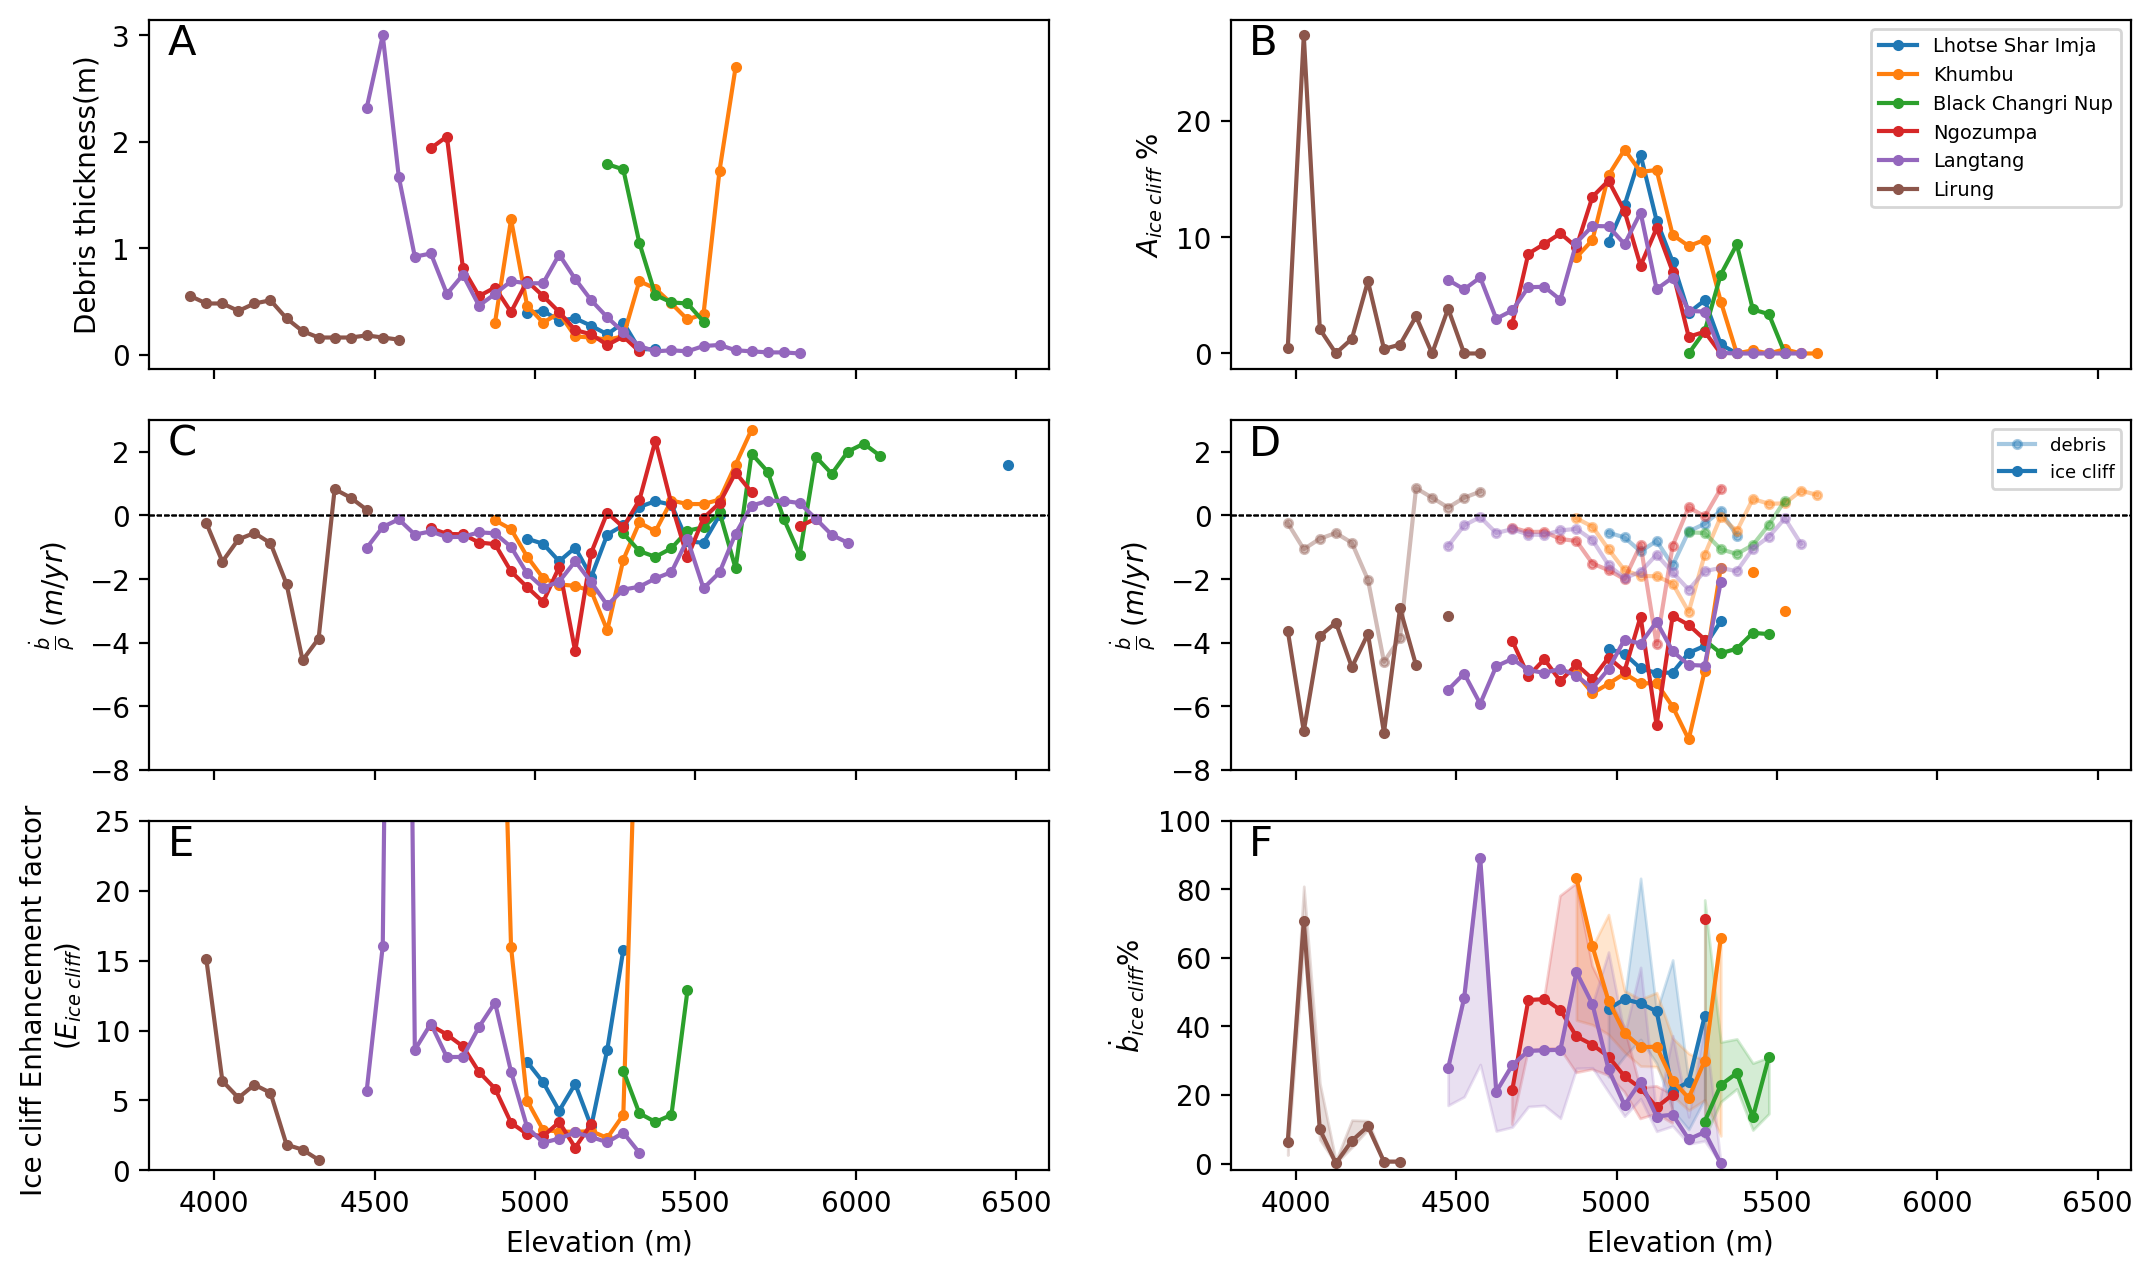

In [21]:
stats_df_list = [imja_stats,khumbu_stats,black_changri_stats,ngozumpa_stats,langtang_stats,lirung_stats]
ms = 3
f,axa = plt.subplots(3,2,sharex=True,figsize=(11,6.5))
ax = axa.ravel()

## first columnt contains enhancement factor

for idx in range(len(glac_name)):
    ax[0].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].med_deb_thick, marker='o',markersize=ms)
    
    
    ax[1].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_area_perc,label=glac_name[idx], marker='o',markersize=ms)
    plot_df = stats_df_list[idx].copy()
    mask = plot_df['area_total'] < area_sqkm_threshold
    plot_var = plot_df['med_total_dhdt']
    plot_var[mask] = np.nan
    ax[2].plot(stats_df_list[idx].z_bin_centers,plot_var,label=glac_name[idx], marker='o',markersize=ms)
        
    line, = ax[3].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].med_bg_dhdt,label='debris', marker='o',markersize=ms,alpha=(0.4))
    ax[3].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].med_hotspot_dhdt,label='ice cliff',color=line.get_color(), 
               marker='o',markersize=ms)
    if idx == 0:
        ax[3].legend(prop={'size': 6.5})
        leg = ax[3].get_legend()
        leg.legend_handles[0].set_color(line.get_color())
        leg.legend_handles[1].set_color(line.get_color())
    
    ax[4].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_enhancement_factor,label=glac_name[idx], marker='o',markersize=ms)
    
    line, = ax[5].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_melt_contribution2,label=glac_name[idx], marker='o',markersize=ms)
    ax[5].fill_between(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_melt_contribution2_upper,
                       stats_df_list[idx].ice_cliff_melt_contribution2_lower,label=glac_name[idx],
                      color=line.get_color(),alpha=0.2)
    #ax[3].legend()
    
    ax[4].set_xlabel('Elevation (m)')
    ax[5].set_xlabel('Elevation (m)')
    ax[0].set_ylabel('Debris thickness(m)')
    
    ax[1].set_ylabel(r'$A_{{ice \;  cliff}}$ %')
    
    #ax[2].set_ylabel(r'${\frac{\dot{b}}{\rho}}_{debris+ice \; cliff}\;(m/yr)$')
    ax[2].set_ylabel(r'$\frac{\dot{b}}{\rho}\;(m/yr)$')
    ax[3].set_ylabel(r'$\frac{\dot{b}}{\rho}\;(m/yr)$')
    #ax[3].set_ylabel(r'$\dot{b}_{ice \; cliff}\;(m/yr)$')
    ax[4].set_ylabel('Ice cliff Enhancement factor \n' + r'($E_{ice \; cliff}$)')
    ax[5].set_ylabel(r'$\dot{b}_{ice \; cliff}\%$')
    ax[2].set_ylim(-8,3)
    ax[2].axhline(y=0.0,linewidth=0.5,linestyle='--',c='k')
    ax[3].set_ylim(-8,3)
    ax[3].axhline(y=0.0,linewidth=0.5,linestyle='--',c='k')
    ax[4].set_ylim(0,25)
    ax[5].set_ylim(-2,100)
   
    
#ax[0].axhline(y=0.04,linewidth=0.5,linestyle='--',c='k',label='Critical thickness')
#ax[3].legend()
ax[1].legend(loc='upper right',prop={'size': 7})
for axa in ax.ravel():
    axa.set_prop_cycle(color=colors)


ax[0].text(0.020,0.90,'A',
    color='k', fontsize=15,transform=ax[0].transAxes)
ax[1].text(0.020,0.90,'B',
    color='k', fontsize=15,transform=ax[1].transAxes)
ax[2].text(0.020,0.90,'C',
    color='k', fontsize=15,transform=ax[2].transAxes)
ax[3].text(0.020,0.90,'D',
    color='k', fontsize=15,transform=ax[3].transAxes)
ax[4].text(0.020,0.90,'E',
    color='k', fontsize=15,transform=ax[4].transAxes)
ax[5].text(0.020,0.90,'F',
    color='k', fontsize=15,transform=ax[5].transAxes)
plt.tight_layout()
#plt.savefig('/nobackup/sbhusha1/chapter2/figures/Debris_ice_cliff_melt_summary_clim_mf_6panel_spread.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

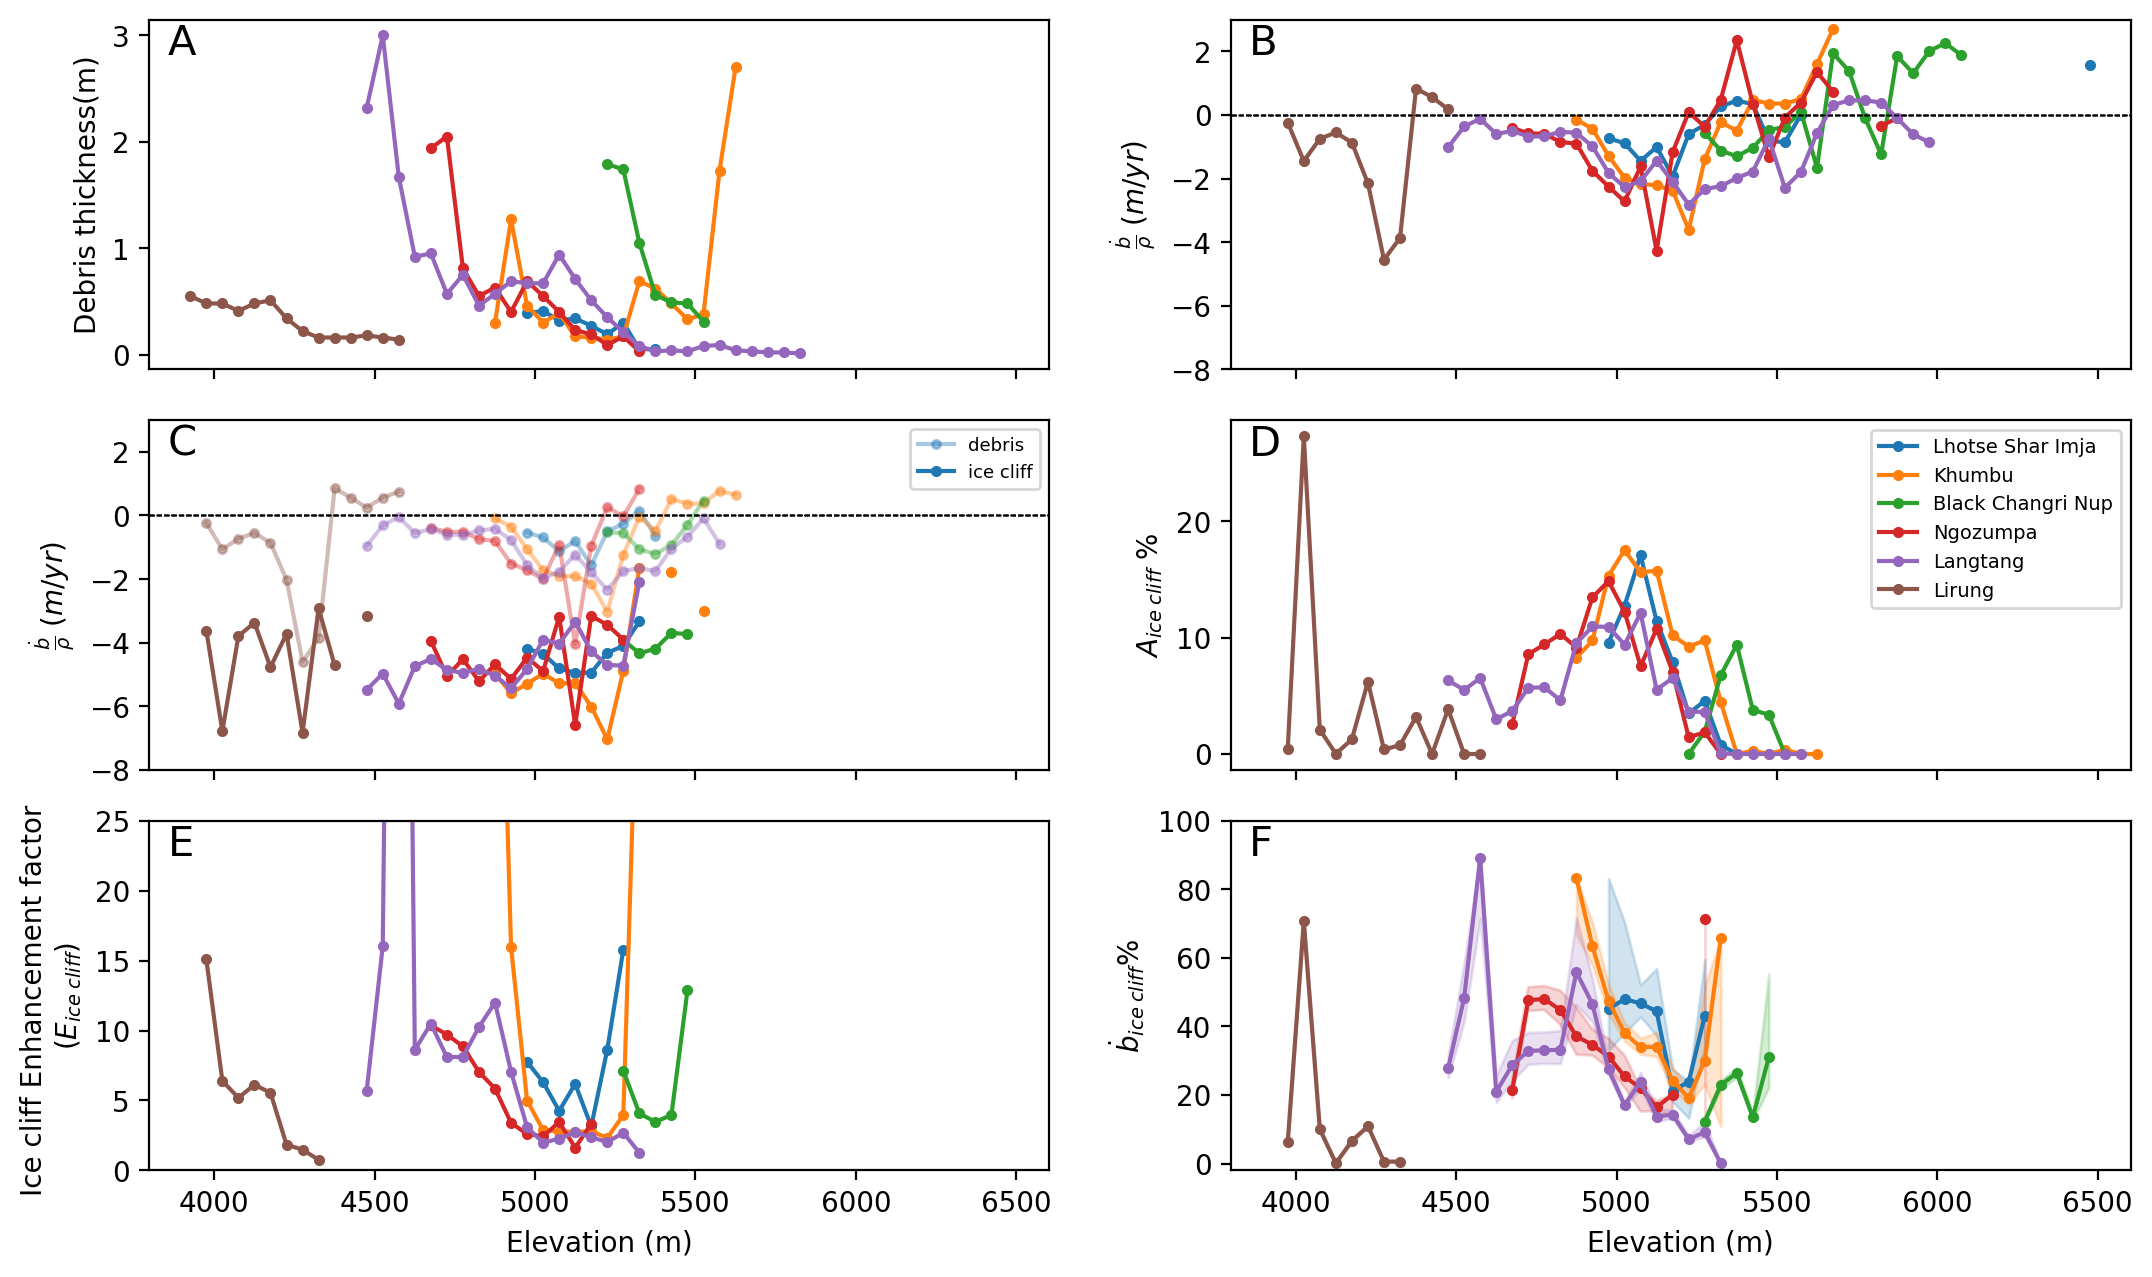

In [19]:
stats_df_list = [imja_stats,khumbu_stats,black_changri_stats,ngozumpa_stats,langtang_stats,lirung_stats]
ms = 3
f,axa = plt.subplots(3,2,sharex=True,figsize=(11,6.5))
ax = axa.ravel()

## first columnt contains enhancement factor

for idx in range(len(glac_name)):
    ax[0].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].med_deb_thick, marker='o',markersize=ms)
    
    plot_df = stats_df_list[idx].copy()
    mask = plot_df['area_total'] < area_sqkm_threshold
    plot_var = plot_df['med_total_dhdt']
    plot_var[mask] = np.nan
    ax[1].plot(stats_df_list[idx].z_bin_centers,plot_var,label=glac_name[idx], marker='o',markersize=ms)
        
    line, = ax[2].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].med_bg_dhdt,label='debris', marker='o',markersize=ms,alpha=(0.4))
    ax[2].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].med_hotspot_dhdt,label='ice cliff',color=line.get_color(), 
               marker='o',markersize=ms)
    if idx == 0:
        ax[2].legend(prop={'size': 6.5})
        leg = ax[2].get_legend()
        leg.legend_handles[0].set_color(line.get_color())
        leg.legend_handles[1].set_color(line.get_color())
        
    ax[3].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_area_perc,label=glac_name[idx], marker='o',markersize=ms)
    
    
    
    
    ax[4].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_enhancement_factor,label=glac_name[idx], marker='o',markersize=ms)
    
    line, = ax[5].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_melt_contribution2,label=glac_name[idx], marker='o',markersize=ms)
    ax[5].fill_between(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_melt_contribution2_upper,
                       stats_df_list[idx].ice_cliff_melt_contribution2_lower,label=glac_name[idx],
                      color=line.get_color(),alpha=0.2)
    #ax[3].legend()
    
    ax[4].set_xlabel('Elevation (m)')
    ax[5].set_xlabel('Elevation (m)')
    ax[0].set_ylabel('Debris thickness(m)')
    ax[1].set_ylabel(r'$\frac{\dot{b}}{\rho}\;(m/yr)$')
    ax[2].set_ylabel(r'$\frac{\dot{b}}{\rho}\;(m/yr)$')
    
    ax[3].set_ylabel(r'$A_{{ice \;  cliff}}$ %')
    
    #ax[2].set_ylabel(r'${\frac{\dot{b}}{\rho}}_{debris+ice \; cliff}\;(m/yr)$')
    
    #ax[3].set_ylabel(r'$\dot{b}_{ice \; cliff}\;(m/yr)$')
    ax[4].set_ylabel('Ice cliff Enhancement factor \n' + r'($E_{ice \; cliff}$)')
    ax[5].set_ylabel(r'$\dot{b}_{ice \; cliff}\%$')
    ax[1].set_ylim(-8,3)
    ax[1].axhline(y=0.0,linewidth=0.5,linestyle='--',c='k')
    ax[2].set_ylim(-8,3)
    ax[2].axhline(y=0.0,linewidth=0.5,linestyle='--',c='k')
    ax[4].set_ylim(0,25)
    ax[5].set_ylim(-2,100)
   
    
#ax[0].axhline(y=0.04,linewidth=0.5,linestyle='--',c='k',label='Critical thickness')
#ax[3].legend()
ax[3].legend(loc='upper right',prop={'size': 7})
for axa in ax.ravel():
    axa.set_prop_cycle(color=colors)


ax[0].text(0.020,0.90,'A',
    color='k', fontsize=15,transform=ax[0].transAxes)
ax[1].text(0.020,0.90,'B',
    color='k', fontsize=15,transform=ax[1].transAxes)
ax[2].text(0.020,0.90,'C',
    color='k', fontsize=15,transform=ax[2].transAxes)
ax[3].text(0.020,0.90,'D',
    color='k', fontsize=15,transform=ax[3].transAxes)
ax[4].text(0.020,0.90,'E',
    color='k', fontsize=15,transform=ax[4].transAxes)
ax[5].text(0.020,0.90,'F',
    color='k', fontsize=15,transform=ax[5].transAxes)
plt.tight_layout()
plt.savefig('/nobackup/sbhusha1/chapter2/figures/Debris_ice_cliff_melt_summary_clim_mf_6panel_spread.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

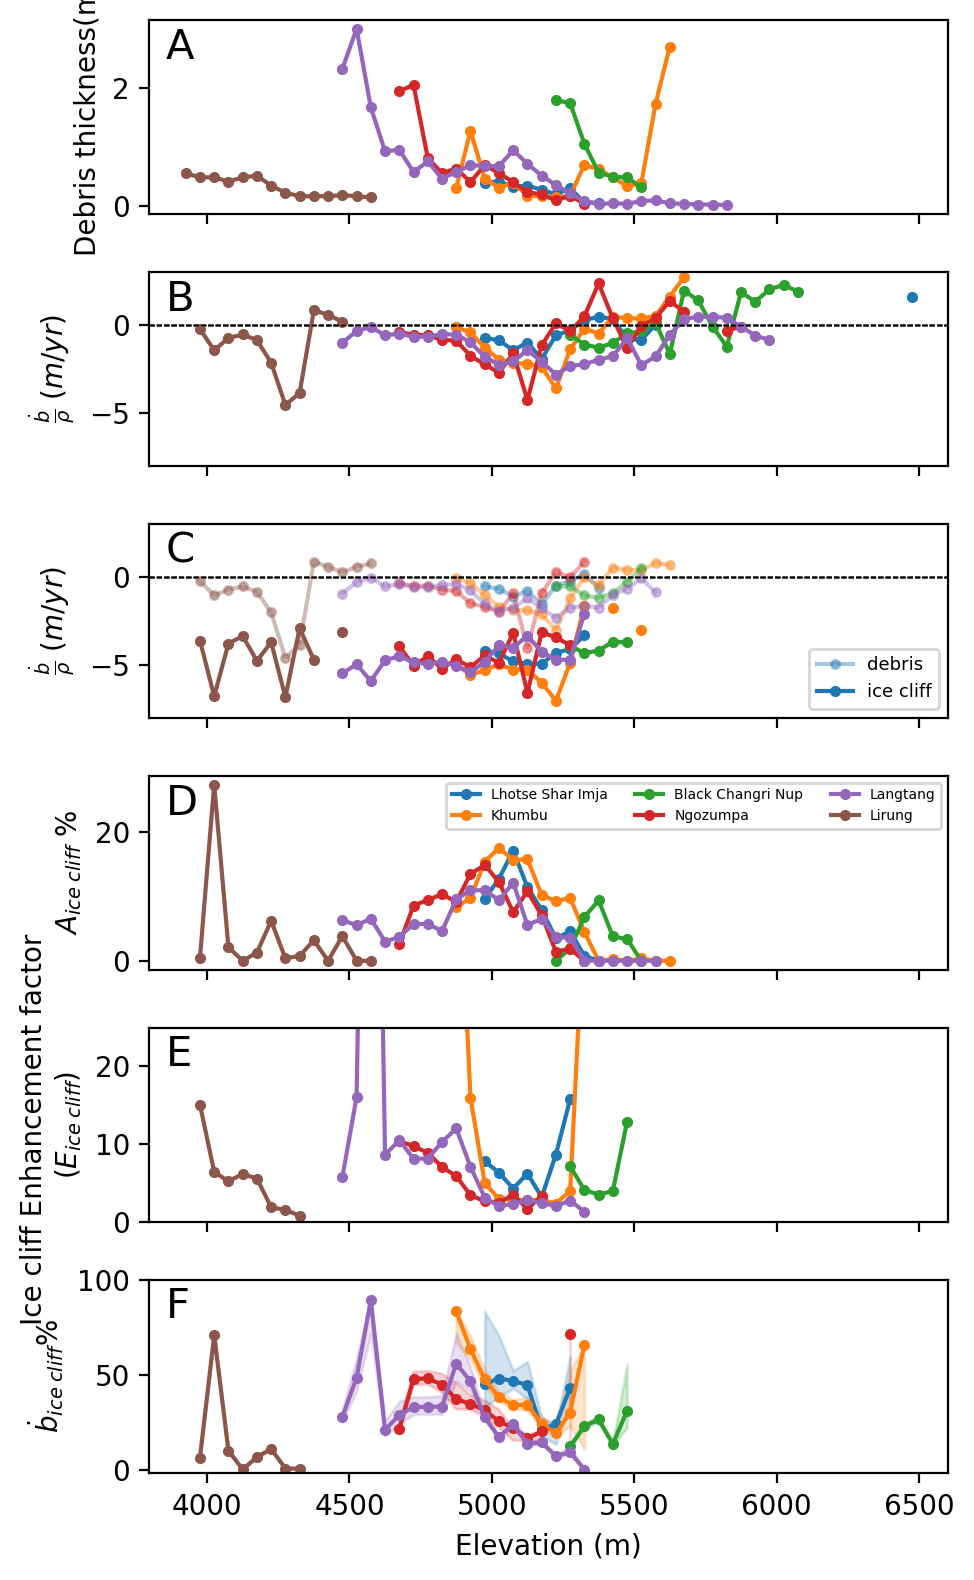

In [20]:
stats_df_list = [imja_stats,khumbu_stats,black_changri_stats,ngozumpa_stats,langtang_stats,lirung_stats]
ms = 3
f,axa = plt.subplots(6,1,sharex=True,figsize=(5,8))
ax = axa.ravel()

## first columnt contains enhancement factor

for idx in range(len(glac_name)):
    ax[0].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].med_deb_thick, marker='o',markersize=ms)
    
    plot_df = stats_df_list[idx].copy()
    mask = plot_df['area_total'] < area_sqkm_threshold
    plot_var = plot_df['med_total_dhdt']
    plot_var[mask] = np.nan
    ax[1].plot(stats_df_list[idx].z_bin_centers,plot_var,label=glac_name[idx], marker='o',markersize=ms)
        
    line, = ax[2].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].med_bg_dhdt,label='debris', marker='o',markersize=ms,alpha=(0.4))
    ax[2].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].med_hotspot_dhdt,label='ice cliff',color=line.get_color(), 
               marker='o',markersize=ms)
    if idx == 0:
        ax[2].legend(prop={'size': 6.5})
        leg = ax[2].get_legend()
        leg.legend_handles[0].set_color(line.get_color())
        leg.legend_handles[1].set_color(line.get_color())
        
    ax[3].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_area_perc,label=glac_name[idx], marker='o',markersize=ms)
    
    
    
    
    ax[4].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_enhancement_factor,label=glac_name[idx], marker='o',markersize=ms)
    
    line, = ax[5].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_melt_contribution2,label=glac_name[idx], marker='o',markersize=ms)
    ax[5].fill_between(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_melt_contribution2_upper,
                       stats_df_list[idx].ice_cliff_melt_contribution2_lower,label=glac_name[idx],
                      color=line.get_color(),alpha=0.2)
    #ax[3].legend()
    
    #ax[4].set_xlabel('Elevation (m)')
    ax[5].set_xlabel('Elevation (m)')
    ax[0].set_ylabel('Debris thickness(m)')
    ax[1].set_ylabel(r'$\frac{\dot{b}}{\rho}\;(m/yr)$')
    ax[2].set_ylabel(r'$\frac{\dot{b}}{\rho}\;(m/yr)$')
    
    ax[3].set_ylabel(r'$A_{{ice \;  cliff}}$ %')
    
    #ax[2].set_ylabel(r'${\frac{\dot{b}}{\rho}}_{debris+ice \; cliff}\;(m/yr)$')
    
    #ax[3].set_ylabel(r'$\dot{b}_{ice \; cliff}\;(m/yr)$')
    ax[4].set_ylabel('Ice cliff Enhancement factor \n' + r'($E_{ice \; cliff}$)')
    ax[5].set_ylabel(r'$\dot{b}_{ice \; cliff}\%$')
    ax[1].set_ylim(-8,3)
    ax[1].axhline(y=0.0,linewidth=0.5,linestyle='--',c='k')
    ax[2].set_ylim(-8,3)
    ax[2].axhline(y=0.0,linewidth=0.5,linestyle='--',c='k')
    ax[4].set_ylim(0,25)
    ax[5].set_ylim(-2,100)
   
    
#ax[0].axhline(y=0.04,linewidth=0.5,linestyle='--',c='k',label='Critical thickness')
#ax[3].legend()
ax[3].legend(loc='upper right',prop={'size': 5},ncol=3)
for axa in ax.ravel():
    axa.set_prop_cycle(color=colors)


ax[0].text(0.020,0.80,'A',
    color='k', fontsize=15,transform=ax[0].transAxes)
ax[1].text(0.020,0.80,'B',
    color='k', fontsize=15,transform=ax[1].transAxes)
ax[2].text(0.020,0.80,'C',
    color='k', fontsize=15,transform=ax[2].transAxes)
ax[3].text(0.020,0.80,'D',
    color='k', fontsize=15,transform=ax[3].transAxes)
ax[4].text(0.020,0.80,'E',
    color='k', fontsize=15,transform=ax[4].transAxes)
ax[5].text(0.020,0.80,'F',
    color='k', fontsize=15,transform=ax[5].transAxes)
plt.tight_layout()
plt.savefig('/nobackup/sbhusha1/chapter2/figures/Debris_ice_cliff_melt_summary_clim_mf_6panel_spread_vertical_stack.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

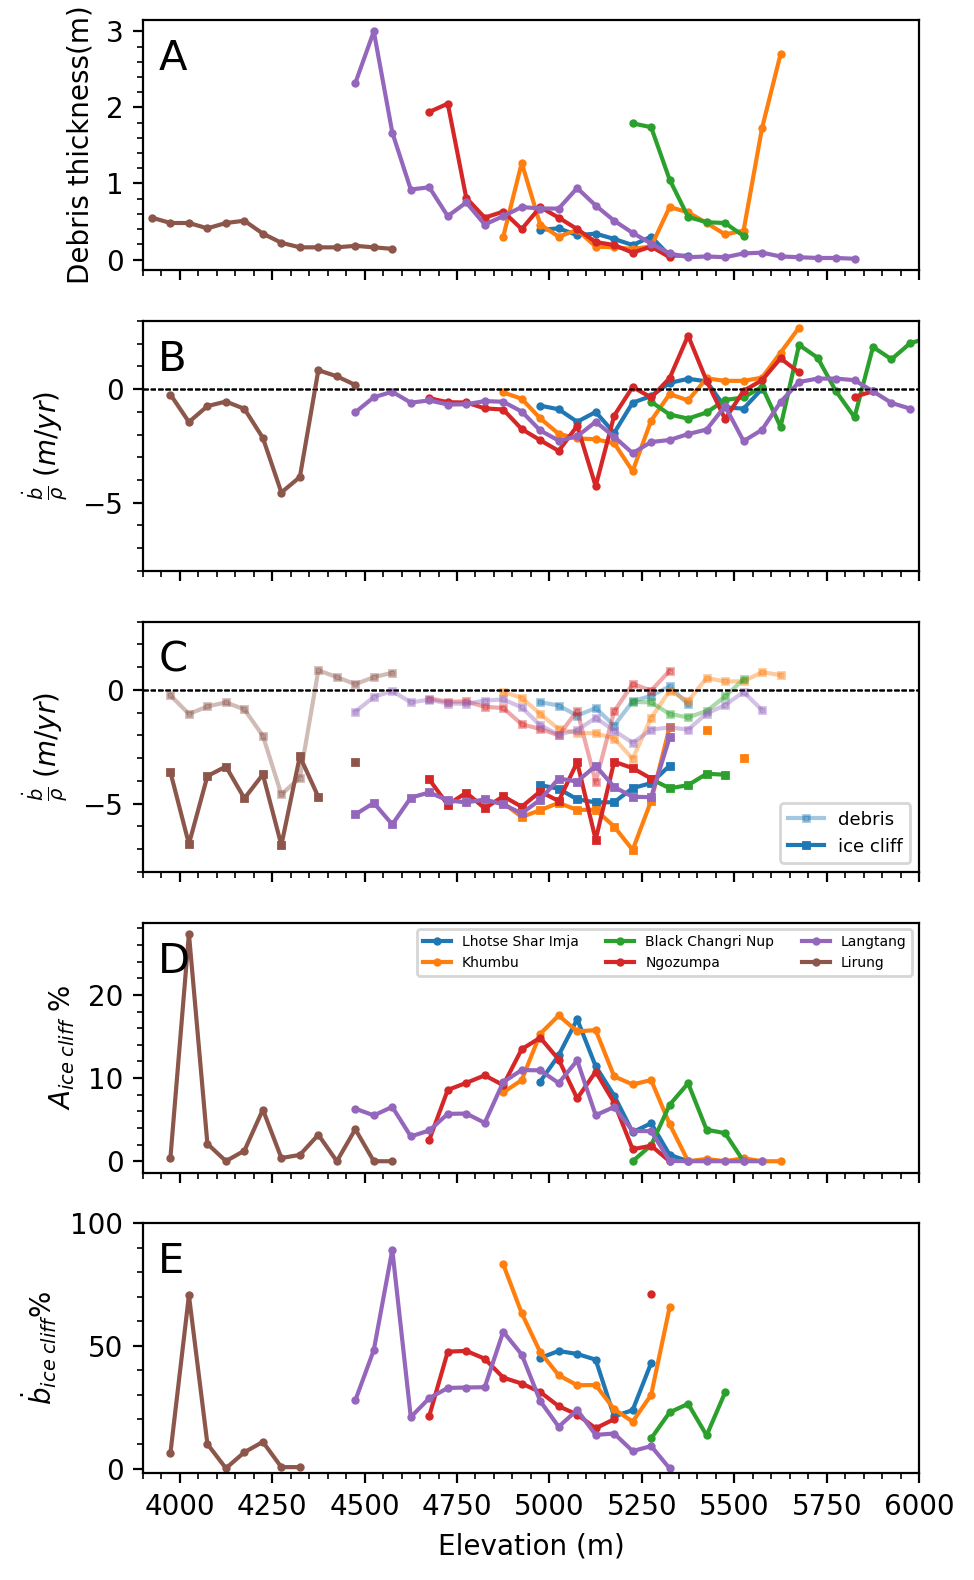

In [29]:
stats_df_list = [imja_stats,khumbu_stats,black_changri_stats,ngozumpa_stats,langtang_stats,lirung_stats]
ms = 2.0
linewidth = 1
f,axa = plt.subplots(5,1,sharex=True,figsize=(5,8))
ax = axa.ravel()

## first columnt contains enhancement factor

for idx in range(len(glac_name)):
    ax[0].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].med_deb_thick, marker='o',markersize=ms)
    
    plot_df = stats_df_list[idx].copy()
    mask = plot_df['area_total'] < area_sqkm_threshold
    plot_var = plot_df['med_total_dhdt']
    plot_var[mask] = np.nan
    ax[1].plot(stats_df_list[idx].z_bin_centers,plot_var,label=glac_name[idx], marker='o',markersize=ms)
        
    line, = ax[2].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].med_bg_dhdt,label='debris', marker='s',markersize=ms,alpha=(0.4))
    ax[2].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].med_hotspot_dhdt,label='ice cliff',color=line.get_color(), 
               marker='s',markersize=ms)
    if idx == 0:
        ax[2].legend(prop={'size': 6.5})
        leg = ax[2].get_legend()
        leg.legend_handles[0].set_color(line.get_color())
        leg.legend_handles[1].set_color(line.get_color())
        
    ax[3].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_area_perc,label=glac_name[idx], marker='o',markersize=ms)
    
    
    
    
    #ax[4].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_enhancement_factor,label=glac_name[idx], marker='o',markersize=ms)
    
    line, = ax[4].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_melt_contribution2,label=glac_name[idx], marker='o',markersize=ms)
    #ax[4].fill_between(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_melt_contribution2_upper,
     #                  stats_df_list[idx].ice_cliff_melt_contribution2_lower,label=glac_name[idx],
      #                color=line.get_color(),alpha=0.2)
    #ax[3].legend()
    
    ax[4].set_xlabel('Elevation (m)')
    
    ax[0].set_ylabel('Debris thickness(m)')
    ax[1].set_ylabel(r'$\frac{\dot{b}}{\rho}\;(m/yr)$')
    ax[2].set_ylabel(r'$\frac{\dot{b}}{\rho}\;(m/yr)$')
    
    ax[3].set_ylabel(r'$A_{{ice \;  cliff}}$ %')
    
    #ax[2].set_ylabel(r'${\frac{\dot{b}}{\rho}}_{debris+ice \; cliff}\;(m/yr)$')
    
    #ax[3].set_ylabel(r'$\dot{b}_{ice \; cliff}\;(m/yr)$')
    #ax[4].set_ylabel('Ice cliff Enhancement factor \n' + r'($E_{ice \; cliff}$)')
    ax[4].set_ylabel(r'$\dot{b}_{ice \; cliff}\%$')
    ax[1].set_ylim(-8,3)
    ax[1].axhline(y=0.0,linewidth=0.5,linestyle='--',c='k')
    ax[2].set_ylim(-8,3)
    ax[2].axhline(y=0.0,linewidth=0.5,linestyle='--',c='k')
    #ax[4].set_ylim(0,25)
    ax[4].set_ylim(-2,100)
   
    
#ax[0].axhline(y=0.04,linewidth=0.5,linestyle='--',c='k',label='Critical thickness')
#ax[3].legend()
ax[3].legend(loc='upper right',prop={'size': 5},ncol=3)
for axa in ax.ravel():
    axa.set_prop_cycle(color=colors)
#    axa.tick_params(axis='y',which='minor')
    axa.minorticks_on()
#ax[0].minorticks_on()

ax[0].set_xlim(3900,6000)
ax[0].text(0.020,0.80,'A',
    color='k', fontsize=15,transform=ax[0].transAxes)
ax[1].text(0.020,0.80,'B',
    color='k', fontsize=15,transform=ax[1].transAxes)
ax[2].text(0.020,0.80,'C',
    color='k', fontsize=15,transform=ax[2].transAxes)
ax[3].text(0.020,0.80,'D',
    color='k', fontsize=15,transform=ax[3].transAxes)
ax[4].text(0.020,0.80,'E',
    color='k', fontsize=15,transform=ax[4].transAxes)
#ax[5].text(0.020,0.80,'F',
 #   color='k', fontsize=15,transform=ax[5].transAxes)

plt.tight_layout()
plt.savefig('/nobackup/sbhusha1/chapter2/figures/Debris_ice_cliff_melt_summary_clim_mf_6panel_spread_vertical_stack_no_enhancement.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

## Table 3: Consolidated melt contribution

In [12]:
def glacier_wide_ice_cliff_melt_contribution(df):
    total_debris_melt = (((df['med_hotspot_dhdt']*df['area_hotspot']) + (df['med_bg_dhdt']*df['area_bg']))).sum()
    
    icecliff_melt = (df['med_hotspot_dhdt']*df['area_hotspot']).sum()
    #total_glacier_bg_melt = (df['med_bg_dhdt']*df['area_bg']).sum()/(df['area_bg'].sum())
    return (icecliff_melt/total_debris_melt)*100
def glacier_wide_ice_cliff_enhancement(df):
    area_wt_mean_cliff_melt = ((df['med_hotspot_dhdt']*df['area_hotspot']).sum())/(df['area_hotspot'].sum())
    area_wt_mean_debris_melt = ((df['med_bg_dhdt']*df['area_bg']).sum())/(df['area_bg'].sum())
    glacierwide_icecliff_debris_enhancement = area_wt_mean_cliff_melt/area_wt_mean_debris_melt
    #total_glacier_bg_melt = (df['med_bg_dhdt']*df['area_bg']).sum()/(df['area_bg'].sum())
    return glacierwide_icecliff_debris_enhancement


In [13]:
def glacier_wide_ice_cliff2ice_enhancement(df):
    area_wt_mean_cliff_melt = ((df['med_hotspot_dhdt']*df['area_hotspot']).sum())/(df['area_hotspot'].sum())
    area_wt_mean_ice_melt = (((df['med_bg_dhdt']/df['med_deb_melt_enhancement'])*df['area_bg']).sum())/(df['area_bg'].sum())
    glacierwide_icecliff_ice_enhancement = area_wt_mean_cliff_melt/area_wt_mean_ice_melt
    #total_glacier_bg_melt = (df['med_bg_dhdt']*df['area_bg']).sum()/(df['area_bg'].sum())
    return glacierwide_icecliff_ice_enhancement

In [14]:
glac_stats_list = [imja_stats,khumbu_stats,black_changri_stats,ngozumpa_stats,langtang_stats,lirung_stats]

In [15]:
consolidated_relative_cliff_area_list = []
total_ice_cliff_area_list = []
consolidated_relative_cliff_melt_contribution_list = []
consolidated_melt_enhancement_list = []
consolidated_ice2ice_melt_enhancement_list = []
for idx,glac_df in enumerate(glac_stats_list):
    consolidated_relative_cliff_area_list.append(
        ((glac_df.area_hotspot.sum())/(glac_df.area_hotspot.sum()+glac_df.area_bg.sum()))*100)
    consolidated_relative_cliff_melt_contribution_list.append(
        glacier_wide_ice_cliff_melt_contribution(glac_df))
    total_ice_cliff_area_list.append(glac_df['area_hotspot'].sum())
    consolidated_melt_enhancement_list.append(glacier_wide_ice_cliff_enhancement(glac_df))
    consolidated_ice2ice_melt_enhancement_list.append(glacier_wide_ice_cliff2ice_enhancement(glac_df))

consolidated_melt_df = pd.DataFrame({'glacier':glac_name,'area_ice_cliff_km2':total_ice_cliff_area_list,'area_ice_cliff_perc':consolidated_relative_cliff_area_list,
                                     'ice_cliff_contribution_rel._debris':consolidated_relative_cliff_melt_contribution_list,
                                     'melt_enhancement':consolidated_melt_enhancement_list,'melt_enhancement2ice':consolidated_ice2ice_melt_enhancement_list})
consolidated_melt_df

,glacier,area_ice_cliff_km2,area_ice_cliff_perc,ice_cliff_contribution_rel._debris,melt_enhancement,melt_enhancement2ice
0,Lhotse Shar Imja,0.421844,9.476370,37.867017,5.819184,1.425123
1,Khumbu,0.732316,10.834962,33.437691,4.152322,1.266896
2,Black Changri Nup,0.066544,5.810262,21.585499,4.473442,0.457431
3,Ngozumpa,1.576264,9.387922,30.632938,4.271259,0.584144
4,Langtang,0.985940,6.325792,24.338018,4.683168,0.654112
5,Lirung,0.045724,3.640747,9.829763,2.895545,0.757518


In [18]:
consolidated_relative_cliff_area_list = []
total_ice_cliff_area_list = []
consolidated_relative_cliff_melt_contribution_list = []
consolidated_melt_enhancement_list = []
consolidated_ice2ice_melt_enhancement_list = []
for idx,glac_df in enumerate(glac_stats_list):
    consolidated_relative_cliff_area_list.append(
        ((glac_df.area_hotspot.sum())/(glac_df.area_hotspot.sum()+glac_df.area_bg.sum()))*100)
    consolidated_relative_cliff_melt_contribution_list.append(
        glacier_wide_ice_cliff_melt_contribution(glac_df))
    total_ice_cliff_area_list.append(glac_df['area_hotspot'].sum())
    consolidated_melt_enhancement_list.append(glacier_wide_ice_cliff_enhancement(glac_df))
    consolidated_ice2ice_melt_enhancement_list.append(glacier_wide_ice_cliff2ice_enhancement(glac_df))

consolidated_melt_df = pd.DataFrame({'glacier':glac_name,'area_ice_cliff_km2':total_ice_cliff_area_list,'area_ice_cliff_perc':consolidated_relative_cliff_area_list,
                                     'ice_cliff_contribution_rel._debris':consolidated_relative_cliff_melt_contribution_list,
                                     'melt_enhancement':consolidated_melt_enhancement_list,'melt_enhancement2ice':consolidated_ice2ice_melt_enhancement_list})
consolidated_melt_df

,glacier,area_ice_cliff_km2,area_ice_cliff_perc,ice_cliff_contribution_rel._debris,melt_enhancement,melt_enhancement2ice
0,Lhotse Shar Imja,0.421844,9.476370,37.867017,5.819184,1.425123
1,Khumbu,0.732316,10.834962,33.437691,4.152322,1.266896
2,Black Changri Nup,0.066544,5.810262,21.585499,4.473442,0.457431
3,Ngozumpa,1.576264,9.387922,30.632938,4.271259,0.584144
4,Langtang,0.985940,6.325792,24.338018,4.683168,0.654112
5,Lirung,0.045724,3.640747,9.829763,2.895545,0.757518


## OLD

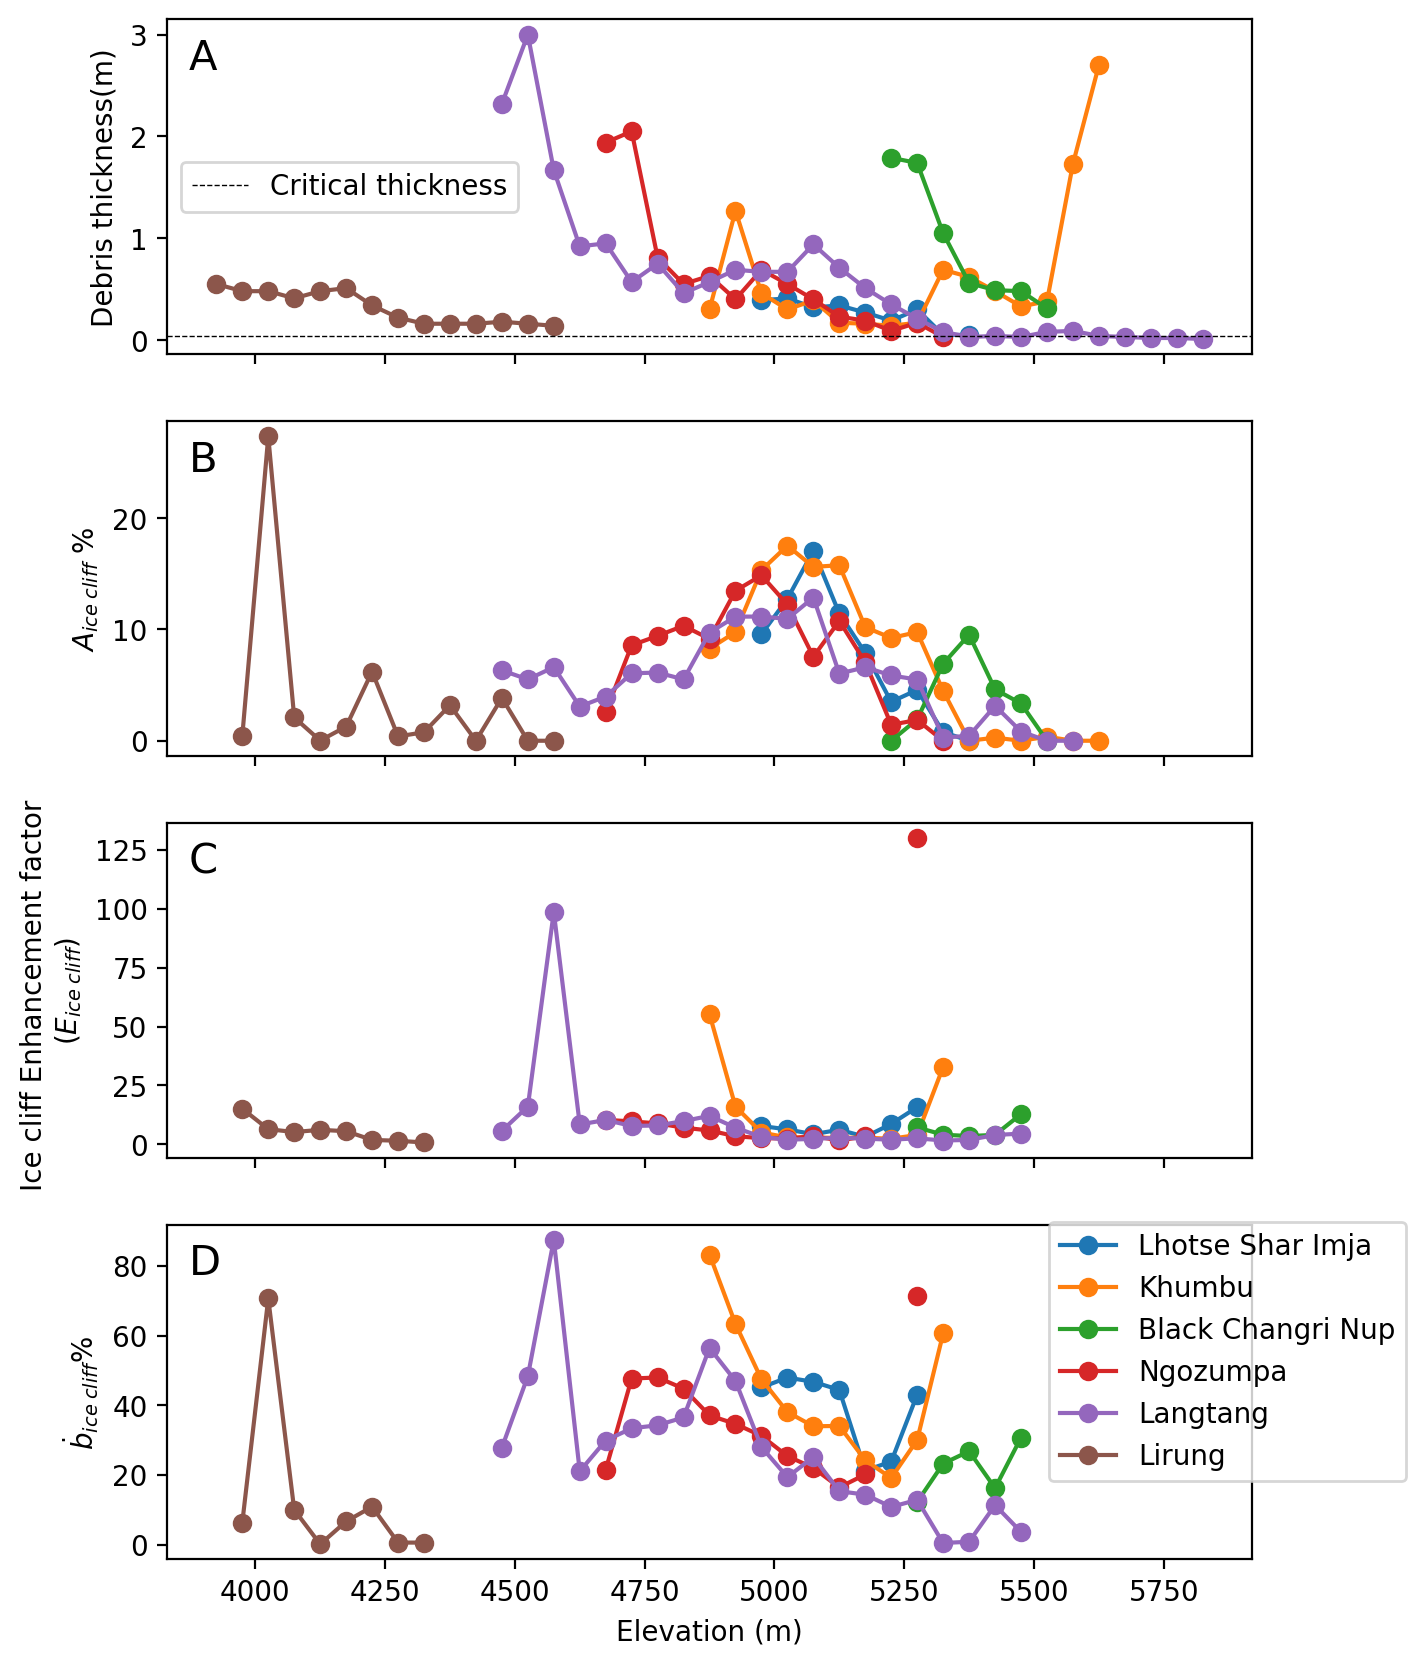

In [43]:
stats_df_list = [imja_stats,khumbu_stats,black_changri_stats,ngozumpa_stats,langtang_stats,lirung_stats]
f,ax = plt.subplots(4,1,sharex=True,figsize=(7,10))
## first columnt contains enhancement factor
for idx in range(len(glac_name)):
    ax[0].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].med_deb_thick, marker='o')
    
    
    ax[1].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_area_perc,label=glac_name[idx], marker='o')
    ax[2].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_enhancement_factor,label=glac_name[idx], marker='o')
    
    ax[3].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_melt_contribution2,label=glac_name[idx], marker='o')
    
    #ax[3].legend()
    
    ax[3].set_xlabel('Elevation (m)')
    ax[0].set_ylabel('Debris thickness(m)')
    ax[1].set_ylabel(r'$A_{{ice \;  cliff}}$ %')
    ax[2].set_ylabel('Ice cliff Enhancement factor \n' + r'($E_{ice \; cliff}$)')
    #ax[3].set_ylabel(r'$\dot{b}_{ice \; cliff}}$%')
    ax[3].set_ylabel(r'$\dot{b}_{ice \; cliff}\%$')
   
    
ax[0].axhline(y=0.04,linewidth=0.5,linestyle='--',c='k',label='Critical thickness')
ax[0].legend()
ax[3].legend(bbox_to_anchor=(0.8, 1.05))
for axa in ax.ravel():
    axa.set_prop_cycle(color=colors)
    
ax[0].text(0.020,0.85,'A',
    color='k', fontsize=15,transform=ax[0].transAxes)
ax[1].text(0.020,0.85,'B',
    color='k', fontsize=15,transform=ax[1].transAxes)
ax[2].text(0.020,0.85,'C',
    color='k', fontsize=15,transform=ax[2].transAxes)
ax[3].text(0.020,0.85,'D',
    color='k', fontsize=15,transform=ax[3].transAxes)
#ax[4].text(0.020,0.92,'E',
 #   color='white', fontsize=15,transform=ax[4].transAxes)
    
plt.savefig('../figures/Debris_ice_cliff_melt_summary.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

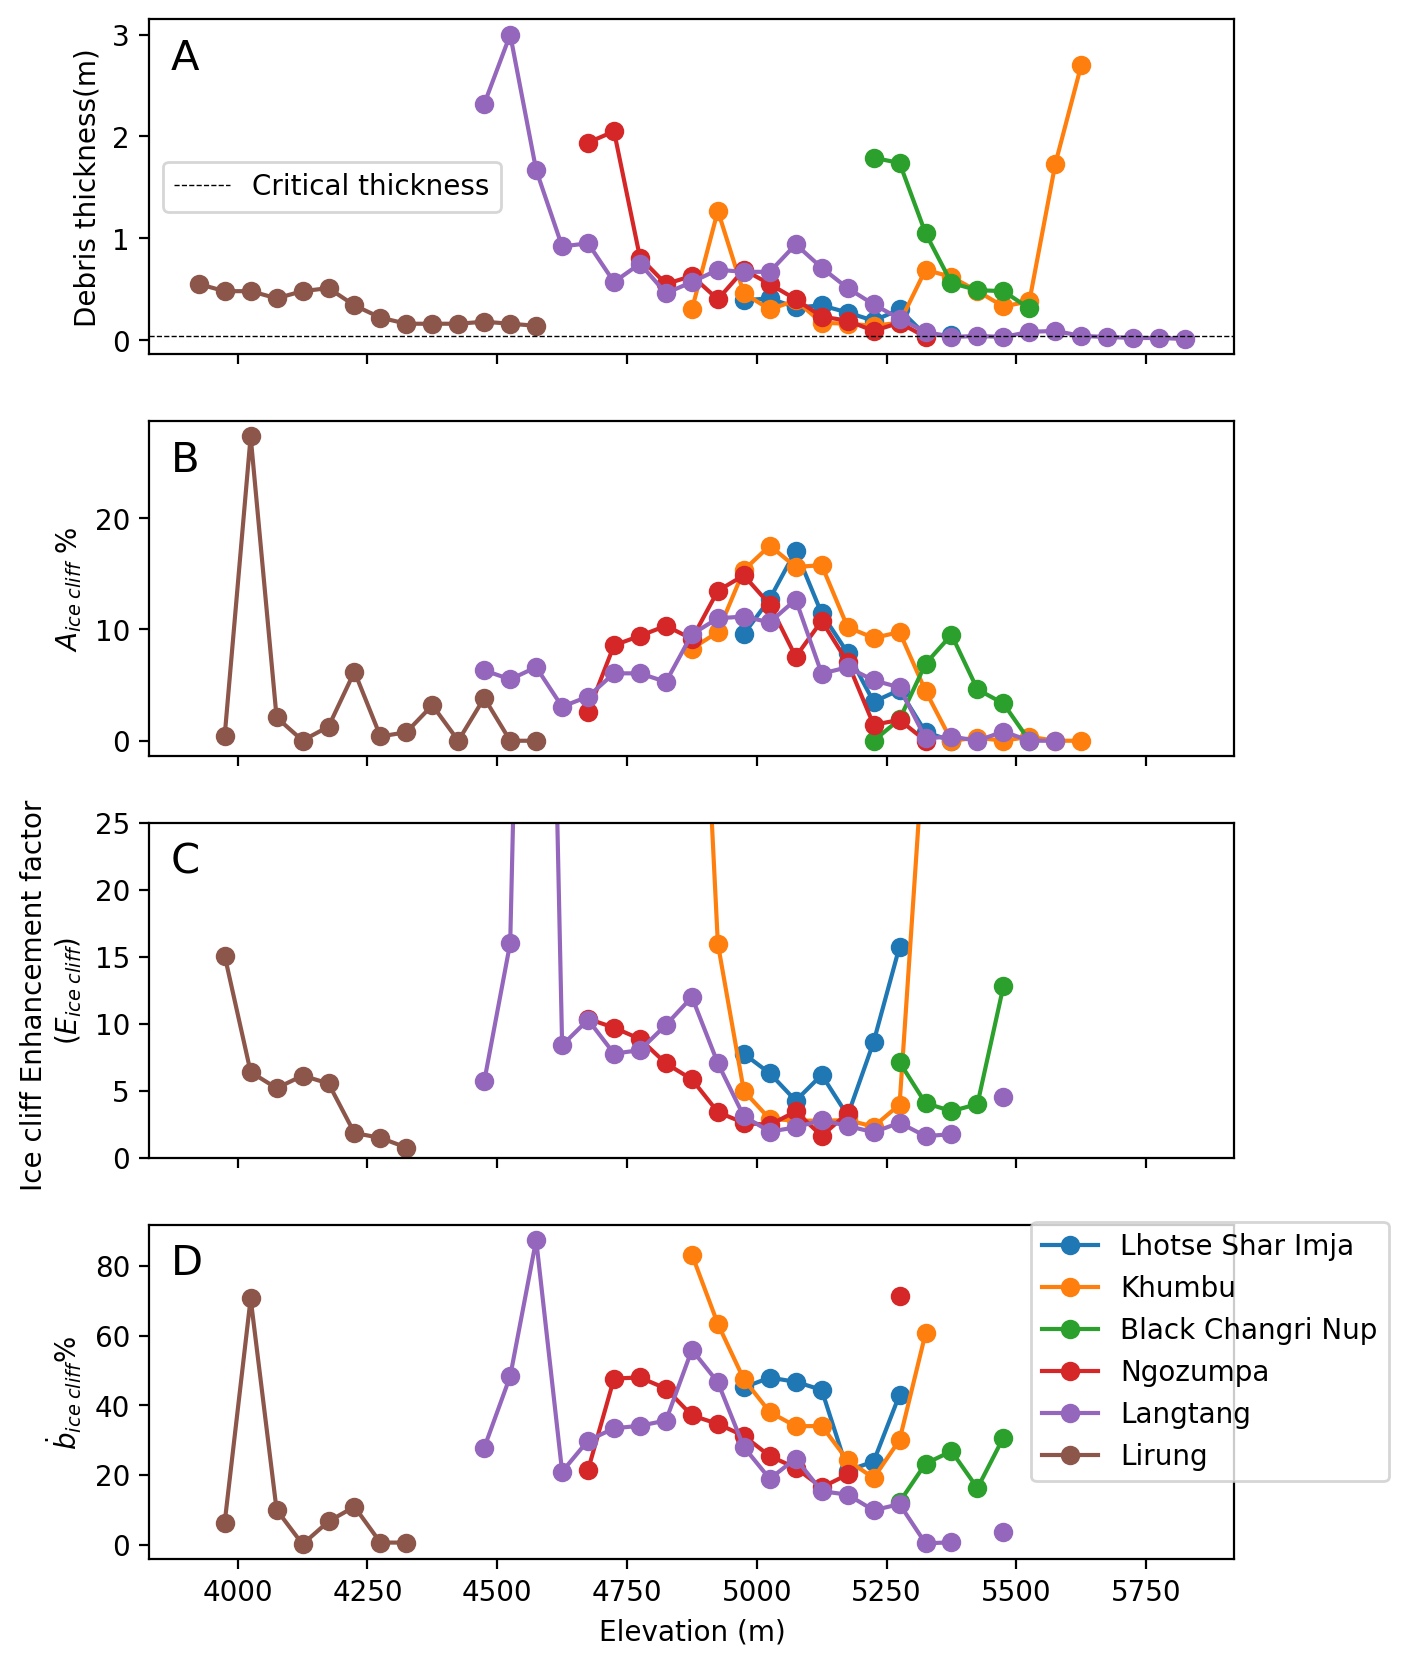

In [10]:
stats_df_list = [imja_stats,khumbu_stats,black_changri_stats,ngozumpa_stats,langtang_stats,lirung_stats]
f,ax = plt.subplots(4,1,sharex=True,figsize=(7,10))
## first columnt contains enhancement factor
for idx in range(len(glac_name)):
    ax[0].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].med_deb_thick, marker='o')
    
    
    ax[1].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_area_perc,label=glac_name[idx], marker='o')
    ax[2].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_enhancement_factor,label=glac_name[idx], marker='o')
    
    ax[3].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_melt_contribution2,label=glac_name[idx], marker='o')
    
    #ax[3].legend()
    
    ax[3].set_xlabel('Elevation (m)')
    ax[0].set_ylabel('Debris thickness(m)')
    
    ax[1].set_ylabel(r'$A_{{ice \;  cliff}}$ %')
    ax[2].set_ylabel('Ice cliff Enhancement factor \n' + r'($E_{ice \; cliff}$)')
    ax[3].set_ylabel(r'$\dot{b}_{ice \; cliff}\%$')
    ax[2].set_ylim(0,25)
   
    
ax[0].axhline(y=0.04,linewidth=0.5,linestyle='--',c='k',label='Critical thickness')
ax[0].legend()
ax[3].legend(bbox_to_anchor=(0.8, 1.05))
for axa in ax.ravel():
    axa.set_prop_cycle(color=colors)
    
ax[0].text(0.020,0.85,'A',
    color='k', fontsize=15,transform=ax[0].transAxes)
ax[1].text(0.020,0.85,'B',
    color='k', fontsize=15,transform=ax[1].transAxes)
ax[2].text(0.020,0.85,'C',
    color='k', fontsize=15,transform=ax[2].transAxes)
ax[3].text(0.020,0.85,'D',
    color='k', fontsize=15,transform=ax[3].transAxes)
#ax[4].text(0.020,0.92,'E',
 #   color='white', fontsize=15,transform=ax[4].transAxes)
    
plt.savefig('../figures/Debris_ice_cliff_melt_summary_clim_mf.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

## Table 4: Consolidated melt contribution

In [68]:
def glacier_wide_ice_cliff_melt_contribution(df):
    total_debris_melt = (((df['med_hotspot_dhdt']*df['area_hotspot']) + (df['med_bg_dhdt']*df['area_bg']))).sum()
    
    icecliff_melt = (df['med_hotspot_dhdt']*df['area_hotspot']).sum()
    #total_glacier_bg_melt = (df['med_bg_dhdt']*df['area_bg']).sum()/(df['area_bg'].sum())
    return (icecliff_melt/total_debris_melt)*100
def glacier_wide_ice_cliff_enhancement(df):
    area_wt_mean_cliff_melt = ((df['med_hotspot_dhdt']*df['area_hotspot']).sum())/(df['area_hotspot'].sum())
    area_wt_mean_debris_melt = ((df['med_bg_dhdt']*df['area_bg']).sum())/(df['area_bg'].sum())
    glacierwide_icecliff_debris_enhancement = area_wt_mean_cliff_melt/area_wt_mean_debris_melt
    #total_glacier_bg_melt = (df['med_bg_dhdt']*df['area_bg']).sum()/(df['area_bg'].sum())
    return glacierwide_icecliff_debris_enhancement

In [13]:

langtang_stats.area_hotspot.sum()

1.0513279999999994

In [14]:
glac_stats_list = [imja_stats,khumbu_stats,black_changri_stats,ngozumpa_stats,langtang_stats,lirung_stats]

In [69]:
consolidated_relative_cliff_area_list = []
total_ice_cliff_area_list = []
consolidated_relative_cliff_melt_contribution_list = []
for idx,glac_df in enumerate(glac_stats_list):
    consolidated_relative_cliff_area_list.append(
        ((glac_df.area_hotspot.sum())/(glac_df.area_hotspot.sum()+glac_df.area_bg.sum()))*100)
    consolidated_relative_cliff_melt_contribution_list.append(
        glacier_wide_ice_cliff_melt_contribution(glac_df))
    total_ice_cliff_area_list.append(glac_df['area_hotspot'].sum())

consolidated_melt_df = pd.DataFrame({'glacier':glac_name,'area_ice_cliff_km2':total_ice_cliff_area_list,'area_ice_cliff_perc':consolidated_relative_cliff_area_list,
                                     'ice_cliff_contribution_rel._debris':consolidated_relative_cliff_melt_contribution_list})
consolidated_melt_df

,glacier,area_ice_cliff_km2,area_ice_cliff_perc,ice_cliff_contribution_rel._debris
0,Lhotse Shar Imja,0.421844,9.477494,37.870450
1,Khumbu,0.732316,10.839914,33.428941
2,Black Changri Nup,0.070000,6.105155,22.478311
3,Ngozumpa,1.576264,9.388248,30.633309
4,Langtang,1.071428,6.892833,25.521878
5,Lirung,0.045724,3.641026,9.829384


In [70]:
stats_df_list[0].keys()

Index(['med_bg_dhdt', 'nmad_bg_dhdt', 'q1_bg_dhdt', 'q3_bg_dhdt', 'area_bg',
       'med_hotspot_dhdt', 'nmad_hotspot_dhdt', 'q1_hotspot_dhdt',
       'q3_hotspot_dhdt', 'area_hotspot', 'med_clean_dhdt', 'nmad_clean_dhdt',
       'q1_clean_dhdt', 'q3_clean_dhdt', 'area_clean', 'med_total_dhdt',
       'nmad_total_dhdt', 'q1_total_dhdt', 'q3_total_dhdt', 'area_total',
       'med_deb_thick', 'nmad_deb_thick', 'q1_deb_thick', 'q3_deb_thick',
       'med_deb_melt_enhancement', 'med_vm', 'nmad_vm', 'q1_vm', 'q3_vm',
       'z_area', 'z_bin_centers', 'melt_debris_total', 'ice_cliff_area_perc',
       'ice_cliff_melt_contribution2', 'ice_cliff_enhancement_factor'],
      dtype='object')

In [36]:
stats_df_list[0][['area_total']]

,area_total
0,0.221880
1,0.825928
2,0.625868
3,0.697628
4,1.014064
...,...
56,0.000000
57,0.000000
58,0.000000
59,0.000000


In [35]:
np.nanpercentile(stats_df_list[0][['area_total']],5)

0.0

,area_total
count,61.000000
mean,0.084105
std,0.222998
min,0.000000
25%,0.000000
50%,0.000000
75%,0.002136
max,1.014064


In [32]:
(np.percentile(stats_df_list[0].area_total,)*1e6)/4

0.0

In [45]:
stats_df_list = [imja_stats,khumbu_stats,black_changri_stats,ngozumpa_stats,langtang_stats,lirung_stats]

In [46]:
area_100_px = 1000 * 2 * 2 * 1e-6

In [49]:
for df in stats_df_list:
    mask = df['area_total'] > area_100_px
    df = df[mask]

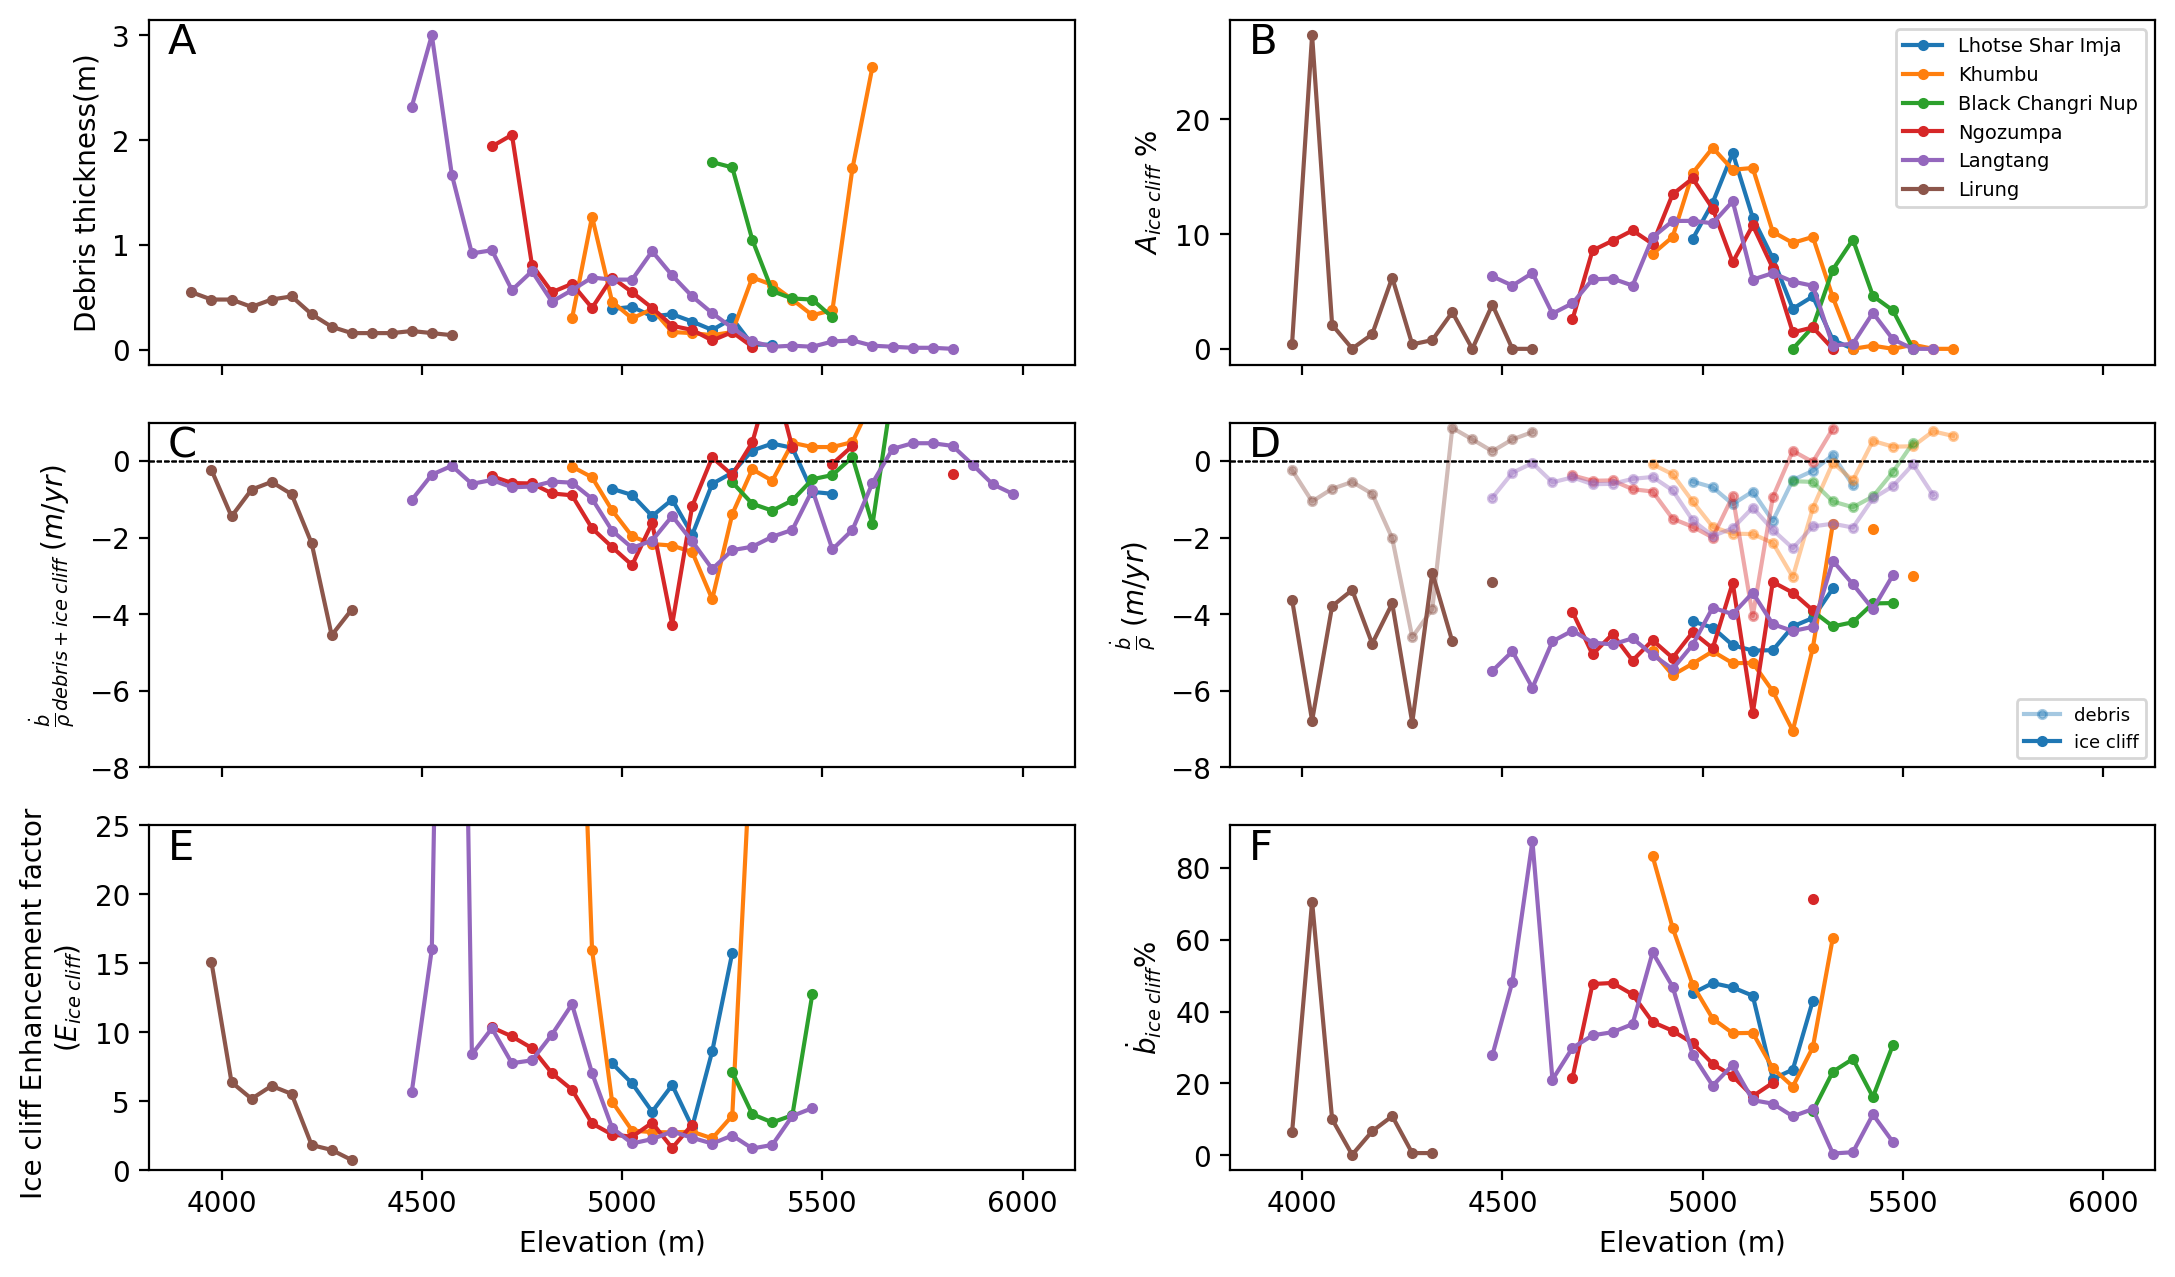

In [61]:

ms = 3
f,axa = plt.subplots(3,2,sharex=True,figsize=(11,6.5))
ax = axa.ravel()

## first columnt contains enhancement factor

for idx in range(len(glac_name)):
    ax[0].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].med_deb_thick, marker='o',markersize=ms)
    
    
    ax[1].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_area_perc,label=glac_name[idx], marker='o',markersize=ms)
    ax[2].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].med_total_dhdt,label=glac_name[idx], marker='o',markersize=ms)
    line, = ax[3].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].med_bg_dhdt,label='debris', marker='o',markersize=ms,alpha=(0.4))
    ax[3].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].med_hotspot_dhdt,label='ice cliff',color=line.get_color(), 
               marker='o',markersize=ms)
    if idx == 0:
        ax[3].legend(prop={'size': 6.5})
        leg = ax[3].get_legend()
        leg.legend_handles[0].set_color(line.get_color())
        leg.legend_handles[1].set_color(line.get_color())
    
    ax[4].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_enhancement_factor,label=glac_name[idx], marker='o',markersize=ms)
    
    ax[5].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_melt_contribution2,label=glac_name[idx], marker='o',markersize=ms)
    
    #ax[3].legend()
    
    ax[4].set_xlabel('Elevation (m)')
    ax[5].set_xlabel('Elevation (m)')
    ax[0].set_ylabel('Debris thickness(m)')
    
    ax[1].set_ylabel(r'$A_{{ice \;  cliff}}$ %')
    
    ax[2].set_ylabel(r'${\frac{\dot{b}}{\rho}}_{debris+ice \; cliff}\;(m/yr)$')
    ax[3].set_ylabel(r'$\frac{\dot{b}}{\rho}\;(m/yr)$')
    #ax[3].set_ylabel(r'$\dot{b}_{ice \; cliff}\;(m/yr)$')
    ax[4].set_ylabel('Ice cliff Enhancement factor \n' + r'($E_{ice \; cliff}$)')
    ax[5].set_ylabel(r'$\dot{b}_{ice \; cliff}\%$')
    ax[2].set_ylim(-8,1)
    ax[2].axhline(y=0.0,linewidth=0.5,linestyle='--',c='k')
    ax[3].set_ylim(-8,1)
    ax[3].axhline(y=0.0,linewidth=0.5,linestyle='--',c='k')
    ax[4].set_ylim(0,25)
   
    
#ax[0].axhline(y=0.04,linewidth=0.5,linestyle='--',c='k',label='Critical thickness')
#ax[3].legend()
ax[1].legend(loc='upper right',prop={'size': 7})
for axa in ax.ravel():
    axa.set_prop_cycle(color=colors)


ax[0].text(0.020,0.90,'A',
    color='k', fontsize=15,transform=ax[0].transAxes)
ax[1].text(0.020,0.90,'B',
    color='k', fontsize=15,transform=ax[1].transAxes)
ax[2].text(0.020,0.90,'C',
    color='k', fontsize=15,transform=ax[2].transAxes)
ax[3].text(0.020,0.90,'D',
    color='k', fontsize=15,transform=ax[3].transAxes)
ax[4].text(0.020,0.90,'E',
    color='k', fontsize=15,transform=ax[4].transAxes)
ax[5].text(0.020,0.90,'F',
    color='k', fontsize=15,transform=ax[5].transAxes)
plt.tight_layout()
plt.savefig('/nobackup/sbhusha1/chapter2/figures/Debris_ice_cliff_melt_summary_clim_mf_6panel.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

In [49]:
np.percentile(np.ma.masked_equal(imja_stats.area_total.values,0).compressed(),(2,5,10))

array([0.00049792, 0.0009448 , 0.001272  ])

In [62]:
area_sqkm_threshold = 0.005

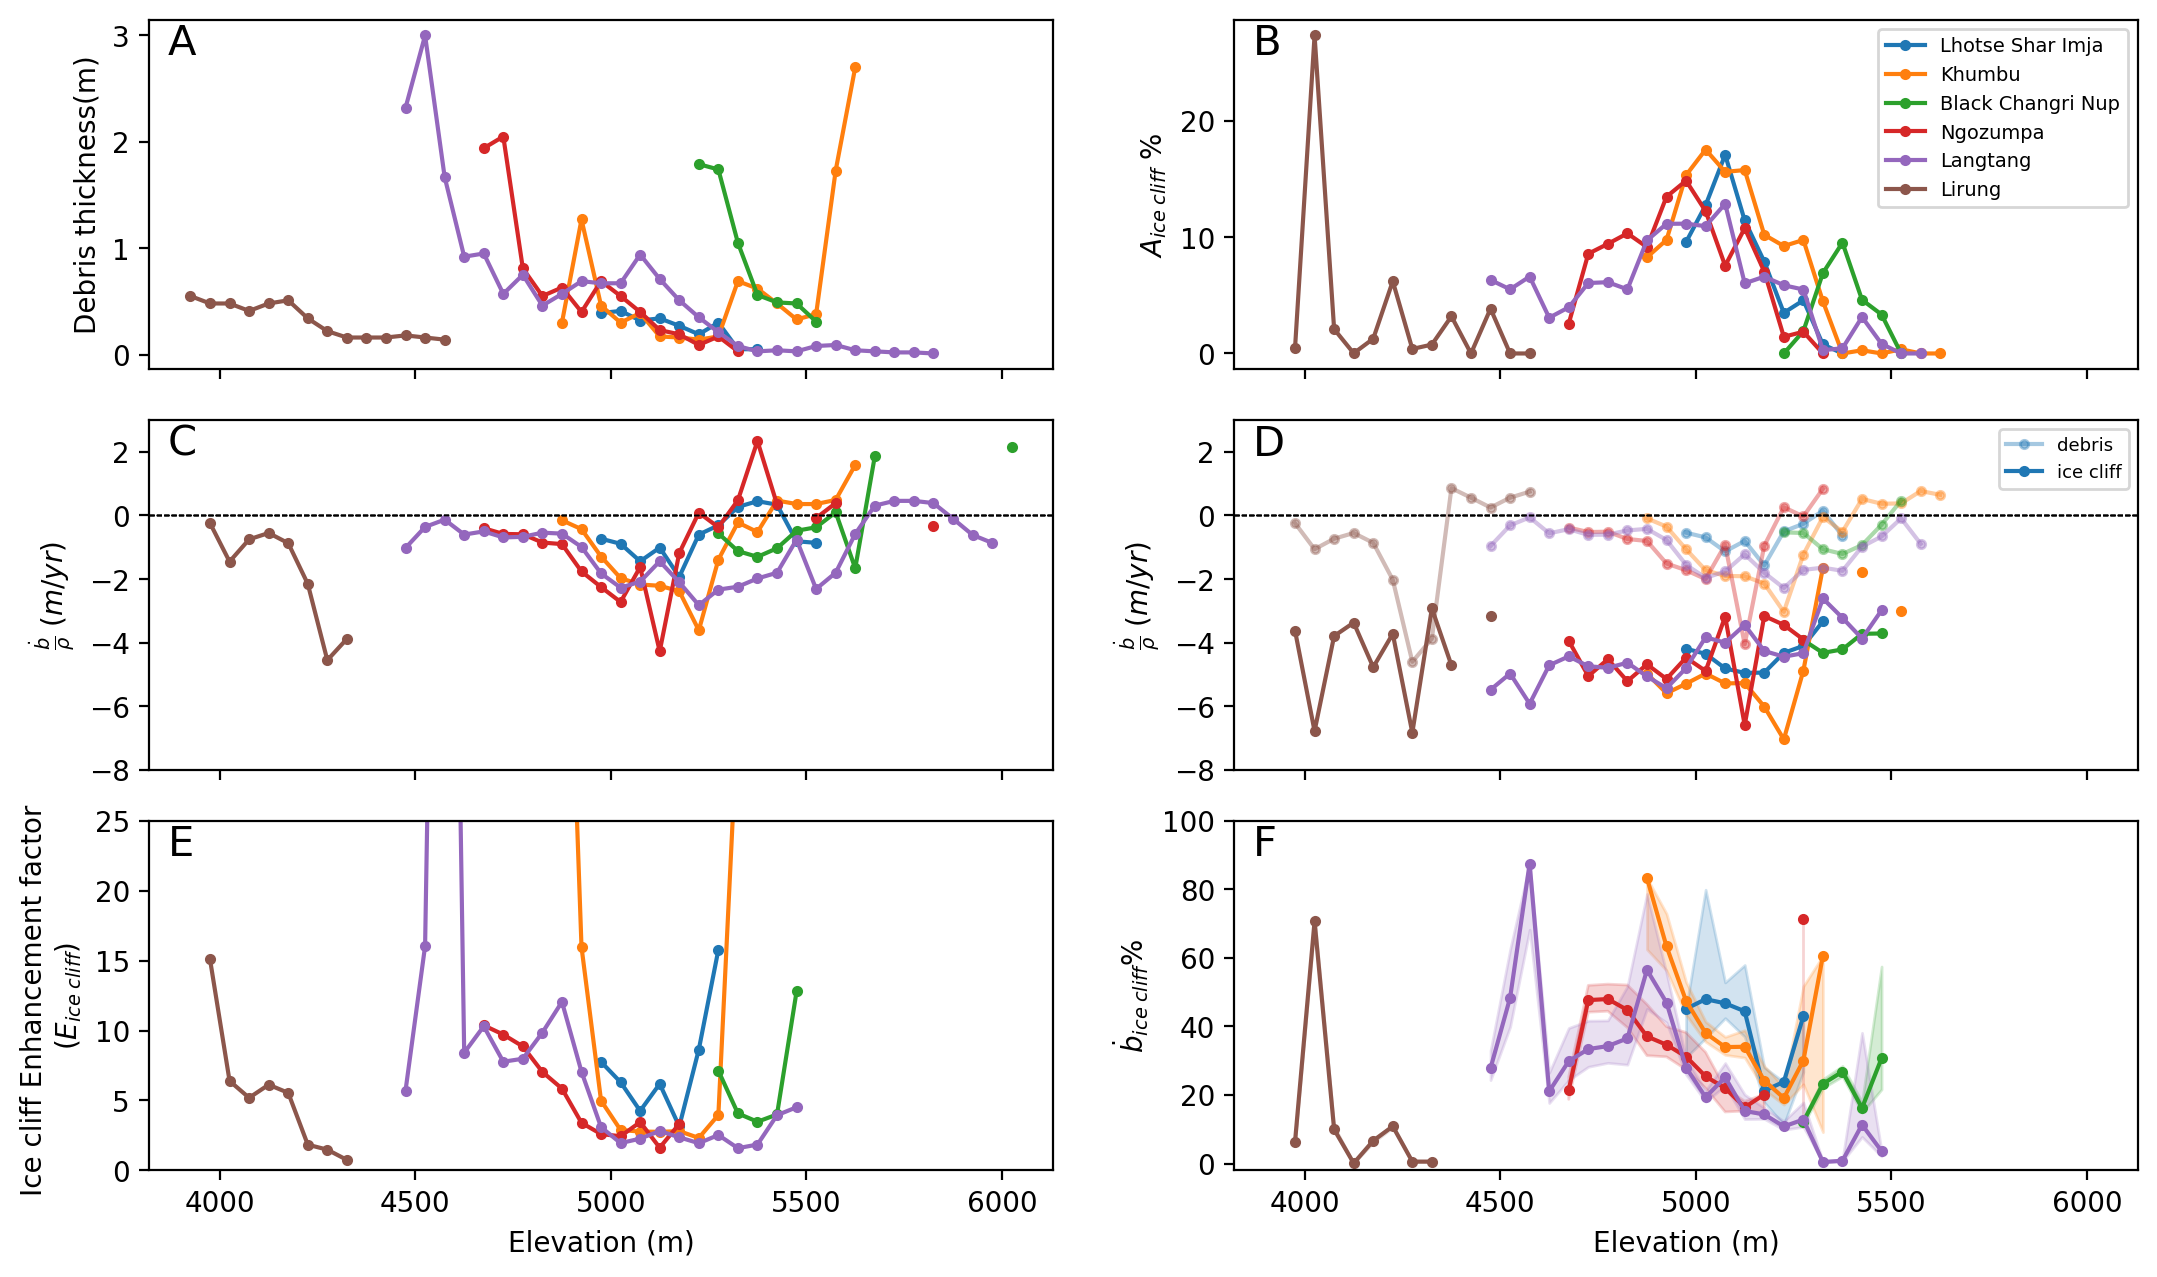

In [63]:
stats_df_list = [imja_stats,khumbu_stats,black_changri_stats,ngozumpa_stats,langtang_stats,lirung_stats]
ms = 3
f,axa = plt.subplots(3,2,sharex=True,figsize=(11,6.5))
ax = axa.ravel()

## first columnt contains enhancement factor

for idx in range(len(glac_name)):
    ax[0].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].med_deb_thick, marker='o',markersize=ms)
    
    
    ax[1].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_area_perc,label=glac_name[idx], marker='o',markersize=ms)
    plot_df = stats_df_list[idx].copy()
    mask = plot_df['area_total'] < area_sqkm_threshold
    plot_var = plot_df['med_total_dhdt']
    plot_var[mask] = np.nan
    ax[2].plot(stats_df_list[idx].z_bin_centers,plot_var,label=glac_name[idx], marker='o',markersize=ms)
        
    line, = ax[3].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].med_bg_dhdt,label='debris', marker='o',markersize=ms,alpha=(0.4))
    ax[3].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].med_hotspot_dhdt,label='ice cliff',color=line.get_color(), 
               marker='o',markersize=ms)
    if idx == 0:
        ax[3].legend(prop={'size': 6.5})
        leg = ax[3].get_legend()
        leg.legend_handles[0].set_color(line.get_color())
        leg.legend_handles[1].set_color(line.get_color())
    
    ax[4].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_enhancement_factor,label=glac_name[idx], marker='o',markersize=ms)
    
    line, = ax[5].plot(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_melt_contribution2,label=glac_name[idx], marker='o',markersize=ms)
    ax[5].fill_between(stats_df_list[idx].z_bin_centers,stats_df_list[idx].ice_cliff_melt_contribution2_upper,
                       stats_df_list[idx].ice_cliff_melt_contribution2_lower,label=glac_name[idx],
                      color=line.get_color(),alpha=0.2)
    #ax[3].legend()
    
    ax[4].set_xlabel('Elevation (m)')
    ax[5].set_xlabel('Elevation (m)')
    ax[0].set_ylabel('Debris thickness(m)')
    
    ax[1].set_ylabel(r'$A_{{ice \;  cliff}}$ %')
    
    #ax[2].set_ylabel(r'${\frac{\dot{b}}{\rho}}_{debris+ice \; cliff}\;(m/yr)$')
    ax[2].set_ylabel(r'$\frac{\dot{b}}{\rho}\;(m/yr)$')
    ax[3].set_ylabel(r'$\frac{\dot{b}}{\rho}\;(m/yr)$')
    #ax[3].set_ylabel(r'$\dot{b}_{ice \; cliff}\;(m/yr)$')
    ax[4].set_ylabel('Ice cliff Enhancement factor \n' + r'($E_{ice \; cliff}$)')
    ax[5].set_ylabel(r'$\dot{b}_{ice \; cliff}\%$')
    ax[2].set_ylim(-8,3)
    ax[2].axhline(y=0.0,linewidth=0.5,linestyle='--',c='k')
    ax[3].set_ylim(-8,3)
    ax[3].axhline(y=0.0,linewidth=0.5,linestyle='--',c='k')
    ax[4].set_ylim(0,25)
    ax[5].set_ylim(-2,100)
   
    
#ax[0].axhline(y=0.04,linewidth=0.5,linestyle='--',c='k',label='Critical thickness')
#ax[3].legend()
ax[1].legend(loc='upper right',prop={'size': 7})
for axa in ax.ravel():
    axa.set_prop_cycle(color=colors)


ax[0].text(0.020,0.90,'A',
    color='k', fontsize=15,transform=ax[0].transAxes)
ax[1].text(0.020,0.90,'B',
    color='k', fontsize=15,transform=ax[1].transAxes)
ax[2].text(0.020,0.90,'C',
    color='k', fontsize=15,transform=ax[2].transAxes)
ax[3].text(0.020,0.90,'D',
    color='k', fontsize=15,transform=ax[3].transAxes)
ax[4].text(0.020,0.90,'E',
    color='k', fontsize=15,transform=ax[4].transAxes)
ax[5].text(0.020,0.90,'F',
    color='k', fontsize=15,transform=ax[5].transAxes)
plt.tight_layout()
plt.savefig('/nobackup/sbhusha1/chapter2/figures/Debris_ice_cliff_melt_summary_clim_mf_6panel_spread.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

In [65]:
glac_stats_list = [imja_stats,khumbu_stats,black_changri_stats,ngozumpa_stats,langtang_stats,lirung_stats]

In [66]:
consolidated_relative_cliff_area_list = []
total_ice_cliff_area_list = []
consolidated_relative_cliff_melt_contribution_list = []
consolidated_melt_enhancement_list = []
for idx,glac_df in enumerate(glac_stats_list):
    consolidated_relative_cliff_area_list.append(
        ((glac_df.area_hotspot.sum())/(glac_df.area_hotspot.sum()+glac_df.area_bg.sum()))*100)
    consolidated_relative_cliff_melt_contribution_list.append(
        glacier_wide_ice_cliff_melt_contribution(glac_df))
    total_ice_cliff_area_list.append(glac_df['area_hotspot'].sum())
    consolidated_melt_enhancement_list.append(glacier_wide_ice_cliff_enhancement(glac_df))

consolidated_melt_df = pd.DataFrame({'glacier':glac_name,'area_ice_cliff_km2':total_ice_cliff_area_list,'area_ice_cliff_perc':consolidated_relative_cliff_area_list,
                                     'ice_cliff_contribution_rel._debris':consolidated_relative_cliff_melt_contribution_list,'melt_enhancement':consolidated_melt_enhancement_list})
consolidated_melt_df

NameError: name 'glacier_wide_ice_cliff_melt_contribution' is not defined